# Introduction

## The purpose of this notebook is to investigate the relationship between geographic location and ACT score, within the United States. This notebook is supplemental to the primary investigation into the impact of socioeconomic factors on academic performance. The full notebook containing the rest of the report can be found here: https://github.com/eligunder/education-inequality/blob/main/Education_Analysis.ipynb


#Data

Data for the additional step was taken from the United States Census Bureau and the United States Zip code Database which can be found

here: https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html#v2022

and here: https://www.unitedstateszipcodes.org/zip-code-database/

respectively.



#Analysis

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
sns.set_theme(style='whitegrid')
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

### Two new files will be read in. A state data frame contains state and population data, while zip_df contains population data for each zip code.

In [217]:

merged_df = pd.read_csv('https://raw.githubusercontent.com/eligunder/education-inequality/main/educ_data_merged.csv')
state_df = pd.read_csv('https://raw.githubusercontent.com/eligunder/education-inequality/main/state_populations.csv', header = 2)
zip_df = pd.read_csv('https://raw.githubusercontent.com/eligunder/education-inequality/main/zip_code_database.csv')

In [218]:
state_df.head()

,Geographic Area,"April 1, 2020 Estimates Base",Population Estimate (as of July 1),Unnamed: 3,Unnamed: 4
0,NaN,NaN,2020.0,2021.0,2022.0
1,United States,331449520.0,331511512.0,332031554.0,333287557.0
2,Northeast,57609156.0,57448898.0,57259257.0,57040406.0
3,Midwest,68985537.0,68961043.0,68836505.0,68787595.0
4,South,126266262.0,126450613.0,127346029.0,128716192.0


## First we will clean the new data. This includes renaming columns, converting data types, and reformatting some of the entries (i.e. removing white space and fixing capitalization)

In [219]:



state_df.rename(columns={"Geographic Area": "state", "Population Estimate (as of July 1)": "population"}, inplace=True)

state_df = state_df.dropna()
state_df["population"] = state_df["population"].astype(int)



state_df = state_df.dropna(subset=["state", "population"])


state_df["state"] = state_df["state"].str.lstrip(".")

state_df["state"] = state_df["state"].str.upper()

state_df = state_df[["state", "population"]]
print(state_df)



                   state  population
1          UNITED STATES   331511512
2              NORTHEAST    57448898
3                MIDWEST    68961043
4                  SOUTH   126450613
5                   WEST    78650958
6                ALABAMA     5031362
7                 ALASKA      732923
8                ARIZONA     7179943
9               ARKANSAS     3014195
10            CALIFORNIA    39501653
11              COLORADO     5784865
12           CONNECTICUT     3597362
13              DELAWARE      992114
14  DISTRICT OF COLUMBIA      670868
15               FLORIDA    21589602
16               GEORGIA    10729828
17                HAWAII     1451043
18                 IDAHO     1849202
19              ILLINOIS    12786580
20               INDIANA     6788799
21                  IOWA     3190571
22                KANSAS     2937919
23              KENTUCKY     4507445
24             LOUISIANA     4651664
25                 MAINE     1363557
26              MARYLAND     6173205
2

<ipython-input-219-3ccedb3a05cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df["population"] = state_df["population"].astype(int)


In [220]:
zip_df.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,501,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.43,-67.15,0


## Now to clean the zip code data. We will only use the zip code and population data from this csv file. We will also create a new column with the first two digits of each zip code in order to sort the data by broader regions.

In [221]:
zip_df = zip_df[["zip", "irs_estimated_population"]]


zip_df["zip_prefix"] = zip_df["zip"].astype(str).str[:2]


total_population_by_prefix = zip_df.groupby("zip_prefix")["irs_estimated_population"].sum().reset_index()


print(total_population_by_prefix)

   zip_prefix  irs_estimated_population
0          10                   4822232
1          11                   7159500
2          12                   1943971
3          13                   1537409
4          14                   2646852
..        ...                       ...
85         95                   6583408
86         96                   1602158
87         97                   3637586
88         98                   5964907
89         99                   1632146

[90 rows x 2 columns]


<ipython-input-221-d74a9a19d877>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_df["zip_prefix"] = zip_df["zip"].astype(str).str[:2]


### Merge the cleaned data frames with the main data frame to use for further analysis on our additional research question. Assign numbers to each state to use as a parameter in a regression model.

In [222]:
merged_df["zip_prefix"] = merged_df["zip_code"].astype(str).str[:2]


merged_df = merged_df.merge(state_df, on="state", how="left")


merged_df = merged_df.merge(total_population_by_prefix, on="zip_prefix", how="left")


state_numbers = {state: i for i, state in enumerate(merged_df["state"].unique(), 1)}

merged_df["state_number"] = merged_df["state"].map(state_numbers)



# Analysis

## First, we will investigate the relationship between average ACT score and the State the school is in using a box plot

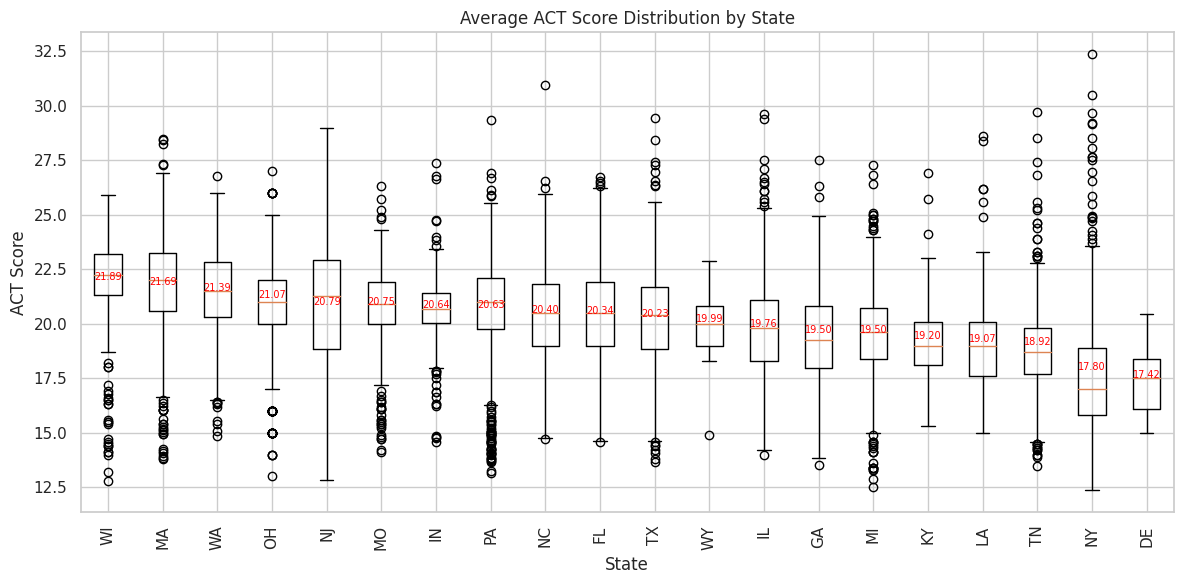

In [223]:
# Group data by state and calculate average ACT score for each state
average_act_by_state = merged_df.groupby('state')['average_act'].mean()

average_act_by_state = average_act_by_state.sort_values(ascending=False)


plt.figure(figsize=(12, 6))
plt.boxplot([merged_df[merged_df['state'] == state]['average_act'] for state in average_act_by_state.index],
            labels=average_act_by_state.index)
plt.title('Average ACT Score Distribution by State')
plt.xlabel('State')
plt.ylabel('ACT Score')
plt.xticks(rotation=90)

#Create labels

for i, state in enumerate(average_act_by_state.index):
    plt.text(i + 1, average_act_by_state[state], f'{average_act_by_state[state]:.2f}',
             horizontalalignment='center', verticalalignment='bottom', color='red', fontsize = 7)


plt.tight_layout()
plt.show()

#### A preliminary analysis shows significant differences in average ACT score between states. It should be noted that Delaware and Wyoming have <40 entries each (as shown in the table below), meaning their averages have a high margin of error.

In [224]:

state_counts = merged_df['state'].value_counts()
print("Counts of each state:")
print(state_counts)


Counts of each state:
state
TX    966
OH    693
PA    601
IL    590
MI    587
FL    441
NC    416
WI    386
NY    385
GA    383
NJ    351
MO    350
IN    347
TN    309
MA    292
WA    273
LA    245
KY    216
WY     38
DE     26
Name: count, dtype: int64


## Zip Code analysis

### Next, we will investigate which zip code prefixes (first two digits) have the highest average ACT score.

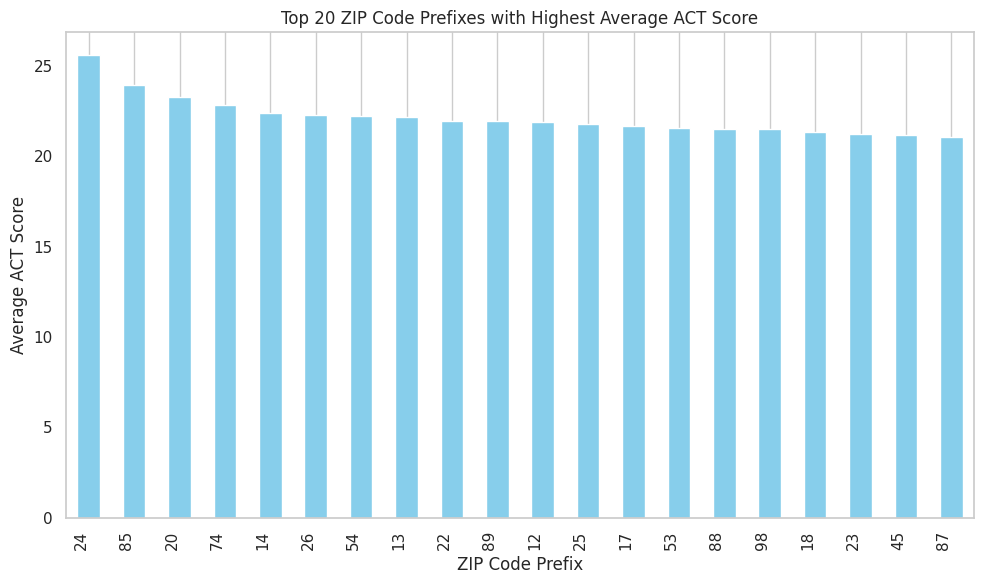

In [225]:
grouped_data = merged_df.groupby('zip_prefix')['average_act'].mean()
grouped_data_sorted = grouped_data.sort_values(ascending=False)

top_20_grouped_data = grouped_data_sorted.head(20)

plt.figure(figsize=(10, 6))
top_20_grouped_data.plot(kind='bar', color='skyblue')
plt.title('Top 20 ZIP Code Prefixes with Highest Average ACT Score')
plt.xlabel('ZIP Code Prefix')
plt.ylabel('Average ACT Score')
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Above are the top 20 zip code prefixes sorted by average ACT score. Let's see the breakdown of which states these zip codes belong to:

In [226]:
state_counts_dict = {}

for zip_prefix in top_20_grouped_data.index:

    state = merged_df.loc[merged_df['zip_prefix'] == zip_prefix, 'state'].iloc[0]

    if state in state_counts_dict:
        state_counts_dict[state] += 1
    else:
        state_counts_dict[state] = 1

print("Dictionary of state counts in the top 20 ZIP code prefixes:")
print(state_counts_dict)

Dictionary of state counts in the top 20 ZIP code prefixes:
{'MA': 11, 'NJ': 5, 'WI': 2, 'WA': 1, 'OH': 1}


#### Over half of the top 20 zip code fixes are from Massachusetts. Regarding the top performing zip code prefixes, these results indicate that there is a relationship between geographic location and academic performance. Next, we will look at the lowest performing zip code prefixes:

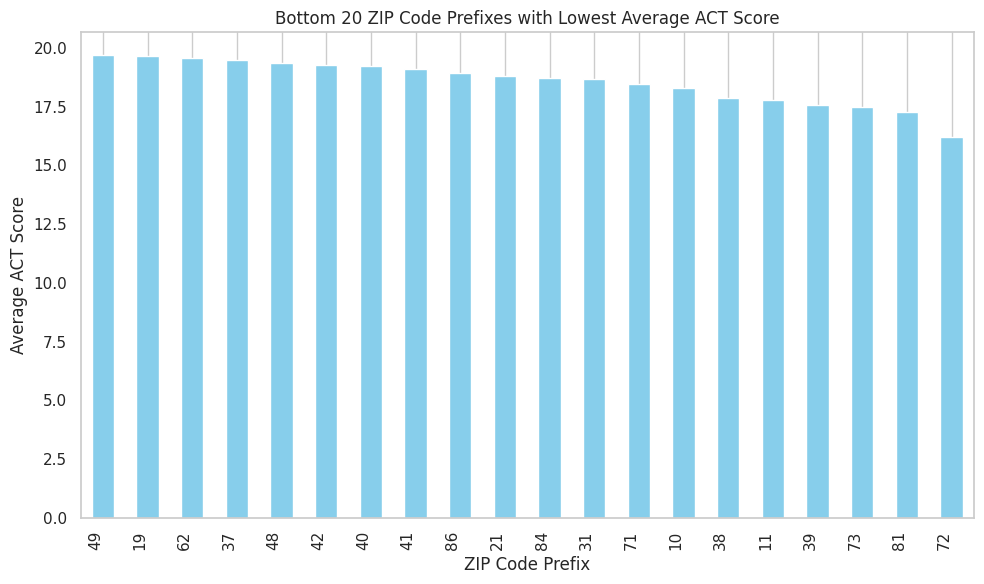

In [227]:
grouped_data = merged_df.groupby('zip_prefix')['average_act'].mean()
grouped_data_sorted = grouped_data.sort_values(ascending=False)

bottom_20_grouped_data = grouped_data_sorted.tail(20)

plt.figure(figsize=(10, 6))
bottom_20_grouped_data.plot(kind='bar', color='skyblue')
plt.title('Bottom 20 ZIP Code Prefixes with Lowest Average ACT Score')
plt.xlabel('ZIP Code Prefix')
plt.ylabel('Average ACT Score')
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Like before, we will see which states these zip codes belong to:

In [228]:
state_counts_dict_lower = {}
for zip_prefix in bottom_20_grouped_data.index:
    state = merged_df.loc[merged_df['zip_prefix'] == zip_prefix, 'state'].iloc[0]

    if state in state_counts_dict_lower:
        state_counts_dict_lower[state] += 1
    else:
        state_counts_dict_lower[state] = 1

sorted_state_counts_lower = dict(sorted(state_counts_dict_lower.items(), key=lambda item: item[1], reverse=True))

print("Dictionary of state counts in the top 20 ZIP code prefixes:")
print(sorted_state_counts_lower)

Dictionary of state counts in the top 20 ZIP code prefixes:
{'NJ': 5, 'KY': 3, 'MA': 3, 'MI': 2, 'TN': 2, 'GA': 2, 'DE': 1, 'IL': 1, 'LA': 1}


#### Unlike the top 20 zip code prefixes, the bottom 20 zip code prefixes seem to be more evenly distributed among all states. It should be noted that New Jersey is overrepresented in both lists, despite only being the 11th most represented state in the entire data set.


## Finally, we will investigate the socioeconomic characteristics of the top 4 and bottom 4 states to determine if this might be influencing the ACT scores

In [229]:
numeric_columns = merged_df.select_dtypes(include=['float64']).columns
mean_by_state = merged_df.groupby('state')[numeric_columns].mean()

sorted_states = mean_by_state['average_act'].sort_values(ascending=False)

top_4_states = sorted_states.head(4).index
bottom_4_states = sorted_states.tail(4).index

mean_by_top_4_states = merged_df[merged_df['state'].isin(top_4_states)].groupby('state')[numeric_columns].mean()

mean_by_bottom_4_states = merged_df[merged_df['state'].isin(bottom_4_states)].groupby('state')[numeric_columns].mean()

print("Mean of each field grouped by the top 4 states:")
print(mean_by_top_4_states)

print("\nMean of each field grouped by the bottom 4 states:")
print(mean_by_bottom_4_states)


Mean of each field grouped by the top 4 states:
       rate_unemployment  percent_college  percent_married  median_income  \
state                                                                       
MA              0.087685         0.685542         0.706145   74939.178694   
OH              0.092950         0.551011         0.658717   51049.808081   
WA              0.093464         0.636805         0.671385   57042.648352   
WI              0.069868         0.596326         0.685887   51742.406736   

       average_act  percent_lunch  population  
state                                          
MA       21.691003       0.295556         NaN  
OH       21.067821       0.396996         NaN  
WA       21.392322       0.373360         NaN  
WI       21.894301       0.297826         NaN  

Mean of each field grouped by the bottom 4 states:
       rate_unemployment  percent_college  percent_married  median_income  \
state                                                                   

#### From a preliminary look, Massachusetts has a high median income, high percent college, and a high percent married relative to other states. This may explain why zip codes in Massachusetts have higher average ACTs. Further investigation into this research question should explore to what extent the relationship between geographic location and ACT score can be explained by socioeconomic factors.

# Linear Regression

## To determine if there is a linear relationship between geographic location and SAT score, a Booster tree regression will be ran, like that which was used in the original research question to determine if there is a correlation between socioeconomic factors and academic performance.

In [230]:
df_mice = merged_df.copy()

X_train, X_test = train_test_split(df_mice, test_size=0.2, random_state=40)

#### Train and test data frames created for the regression. Only the estimated population and state number will be used for this regression. Socioeconomic fields will be excluded in order to strictly measure the effect of geographic location on academic performance.

In [231]:
keep_cols = ['average_act', 'irs_estimated_population', 'state_number']

In [232]:
features = [col for col in keep_cols if col != "average_act"]
target = ["average_act"]
X = X_train[features].values
y = X_train[target].values

X = np.hstack((np.ones_like(y), X))

#### Calculate the beta for the regression equation

In [233]:
beta = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))

#### Check coefficients of the two variables

In [234]:
for feature_name, coeff in zip(X_train[features].columns, beta.squeeze()[1:]):
  print(f"{feature_name}: {coeff:.7f}")
X_without_one = X[:, 1:]

irs_estimated_population: -0.0000001
state_number: 0.0451223


#### Both variables have low coefficients, indicating a weak relationship between them and average ACT.

#### Normalize Data

In [235]:
X_norm = (X_without_one - np.mean(X_without_one, axis=0)) / np.std(X_without_one, axis=0)

#### Run a prediction using the linear regression model. Use the Boost model, as the one used in the original research question, to compare accuracy

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y.squeeze(), test_size=0.3, random_state=42)
xgb = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=1e-1)
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

#### Graph the Boost Tree Regression

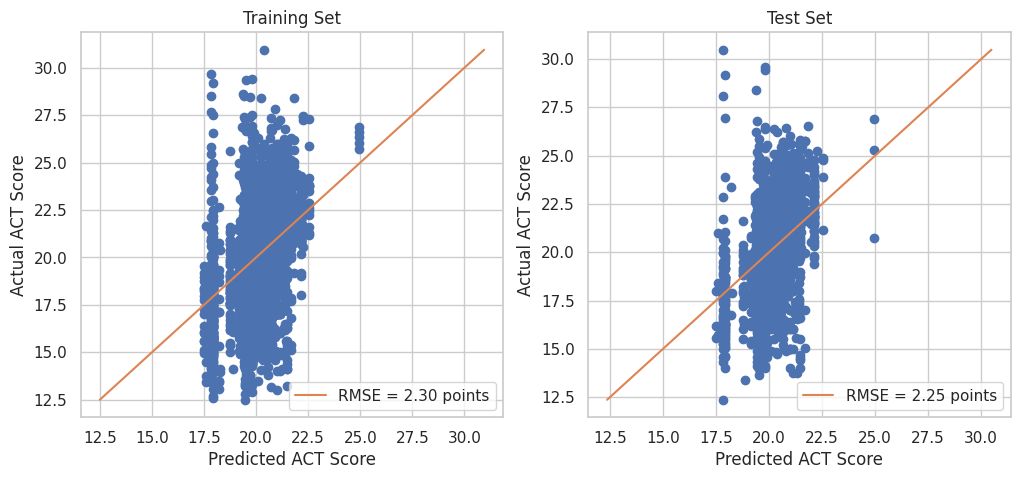

In [237]:
one_train = np.linspace(y_train.min(), y_train.max(), 100)
one_test = np.linspace(y_test.min(), y_test.max(), 100)
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))

fig,(ax1, ax2) = plt.subplots(1, 2)
ax1.plot(y_pred_train, y_train, 'o')
ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} points")
ax1.set_title("Training Set")
ax1.set_xlabel("Predicted ACT Score")
ax1.set_ylabel("Actual ACT Score")
ax1.legend()

ax2.plot(y_pred_test, y_test, 'o')
ax2.plot(one_test, one_test, '-', label=f"RMSE = {rmse_test:.2f} points")
ax2.legend()
ax2.set_title("Test Set")
ax2.set_xlabel("Predicted ACT Score")
ax2.set_ylabel("Actual ACT Score")
fig.set_size_inches(12, 5)


#### This model indicates that there is not a clear linear relationship between geographic location and Predicted ACT score. Let's look at the R2, a measure of how much variation in ACT score can be determined by the geographic parameters used in our model.

In [238]:
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print("R^2 for Training Set:", r2_train)
print("R^2 for Test Set:", r2_test)

R^2 for Training Set: 0.18689289043624868
R^2 for Test Set: 0.17119186928963592


#### An R^2 of 0.17 indicates a weak relationship between the parameters of the model and ACT score

#Conclusion

### In conclusion, while there is some relationship between geographic location and academic performance, there are indicators that this is due to collinearity with socioeconomic factors. No linear relationship was found between geographic location and academic performance.